<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/Analisis/Frecuencia%20inscripciones/NuevasInscripciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis de inscripciones

## Importación de datos

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()

# carga de archivo
raw_csv_data_CL = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_CL.csv")
raw_csv_data_CO = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_CO.csv")
raw_csv_data_DO = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_DO.csv")
raw_csv_data_EC = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_EC.csv")
raw_csv_data_MX = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_MX.csv")
raw_csv_data_PA = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_PA.csv")
raw_csv_data_PE = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_PE.csv")
raw_csv_data_SV = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_SV.csv")



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Estructura y formateo de datos

In [2]:
dateColumnName = "Fecha"
analizedValue = "cantidad"

unused_columns = ['cantidad','FuenteIngreso']

df_comp = pd.concat([raw_csv_data_CL, raw_csv_data_CO, raw_csv_data_DO, raw_csv_data_EC, raw_csv_data_MX, raw_csv_data_PA, raw_csv_data_PE, raw_csv_data_SV])

# formateo de fecha 
df_comp[dateColumnName] = pd.to_datetime(df_comp.Fecha, dayfirst = True)
df_comp = df_comp.groupby([dateColumnName,'FuenteIngreso']).sum().reset_index()
df_comp_UB = df_comp[df_comp.FuenteIngreso == "UB"]

df_comp_UB.set_index(dateColumnName, inplace=True, verify_integrity=True)
df_comp_UB=df_comp_UB.asfreq('d')
df_comp_UB=df_comp_UB.fillna(method='ffill')

df_comp_UB['analizedValue'] = df_comp_UB[analizedValue]

df_comp_UB = df_comp_UB.drop(unused_columns, axis=1)
df_comp_UB.head(5)

,analizedValue
Fecha,
2018-01-02,8
2018-01-03,20
2018-01-04,39
2018-01-05,55
2018-01-06,8


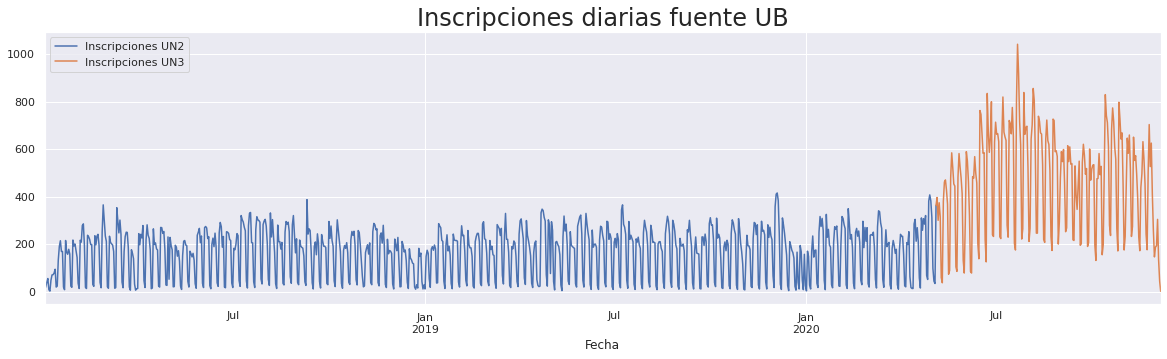

In [3]:
df_comp_UB.analizedValue[:'2020-05-04'].plot(figsize = (20,5), label='Inscripciones UN2')
df_comp_UB.analizedValue['2020-05-04':].plot(figsize = (20,5), label='Inscripciones UN3')
plt.title("Inscripciones diarias fuente UB", size= 24)
plt.legend(loc='upper left')
plt.show()

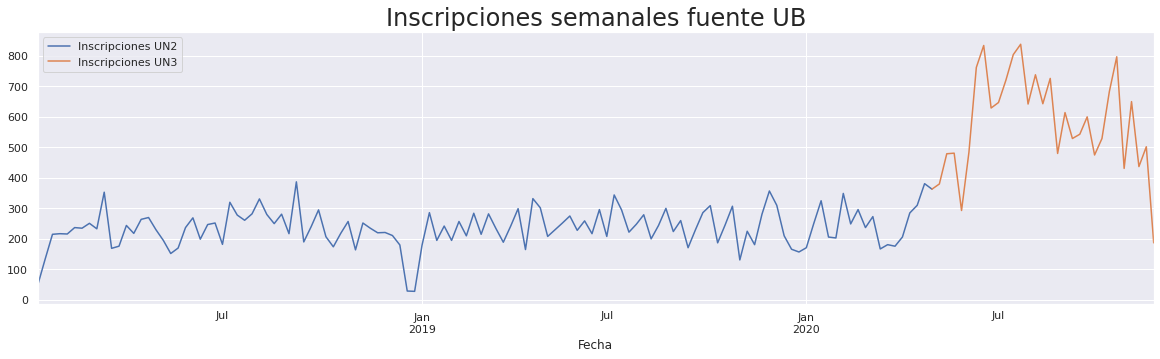

In [4]:
df_comp_UB_w=df_comp_UB.asfreq('W-Mon')

df_comp_UB_w.analizedValue[:'2020-05-04'].plot(figsize = (20,5), label='Inscripciones UN2')
df_comp_UB_w.analizedValue['2020-05-04':].plot(figsize = (20,5), label='Inscripciones UN3')
plt.title("Inscripciones semanales fuente UB", size= 24)
plt.legend(loc='upper left')
plt.show()

## Prueba de estacionalidad

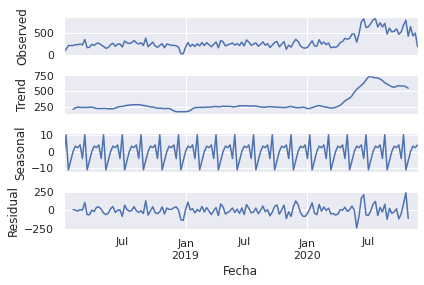

In [18]:
frecuencia = 8

s_dec_additive = seasonal_decompose(df_comp_UB_w.analizedValue, "additive", freq=frecuencia)
s_dec_additive.plot()
plt.show()

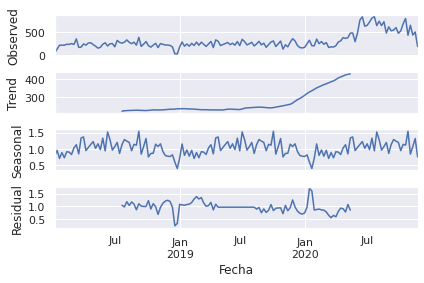

In [11]:
s_dec_multiplicative = seasonal_decompose(df_comp_UB_w.analizedValue, "multiplicative", freq=frecuencia)
s_dec_multiplicative.plot()
plt.show()

## División en entrenamiento y prueba

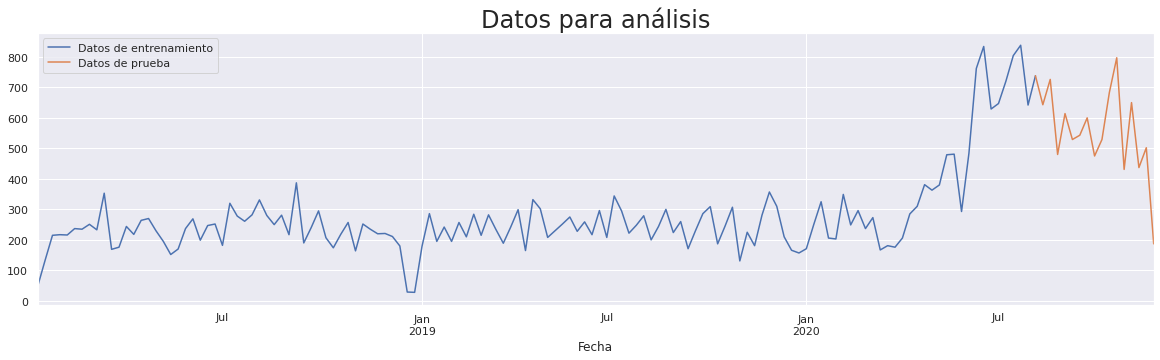

In [6]:
porcentajeEntrenamiento = 0.9
size = int(len(df_comp_UB_w)*porcentajeEntrenamiento)
df_train, df_test = df_comp_UB_w.iloc[:size], df_comp_UB_w.iloc[size-1:]

df_train.analizedValue.plot(figsize = (20,5), label='Datos de entrenamiento')
df_test.analizedValue.plot(figsize = (20,5), label='Datos de prueba')
plt.title("Datos para análisis", size= 24)
plt.legend(loc='upper left')
plt.show()

## Pronóstico con libreria Prophet

### Adecuación de datos

In [7]:
import pandas as pd
from fbprophet import Prophet

dftrain_profet = df_train.reset_index()
dftrain_profet.columns = ['ds','y']
dftrain_profet['ds'] = pd.to_datetime(dftrain_profet['ds'])
dftrain_profet.sample(5)


,ds,y
1,2018-01-15,133
127,2020-06-15,762
53,2019-01-14,286
76,2019-06-24,296
4,2018-02-05,216


### Entrenamiento

In [8]:
additiveModel = Prophet(interval_width=0.95, seasonality_mode='additive')
additiveModel.fit(dftrain_profet)

multiplicativeModel = Prophet(interval_width= 0.95, seasonality_mode='multiplicative')
multiplicativeModel.fit(dftrain_profet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Resultados modelo aditivo

In [9]:
# Generar fechas futuras en base a los datos de prueba
future = additiveModel.make_future_dataframe(periods=len(df_test),freq = 'W-Mon') # 2 años adicionales

forecast = additiveModel.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
148,2020-11-09,611.011733,420.861185,717.504559,602.320537,621.346312,-45.690984,-45.690984,-45.690984,-45.690984,-45.690984,-45.690984,0.0,0.0,0.0,565.320749
149,2020-11-16,618.163086,444.957308,735.261645,608.500214,629.405021,-29.200261,-29.200261,-29.200261,-29.200261,-29.200261,-29.200261,0.0,0.0,0.0,588.962825
150,2020-11-23,625.314440,480.488683,770.502484,614.356006,637.835617,5.709599,5.709599,5.709599,5.709599,5.709599,5.709599,0.0,0.0,0.0,631.024039
151,2020-11-30,632.465793,515.845609,798.918036,620.552071,645.670584,29.752270,29.752270,29.752270,29.752270,29.752270,29.752270,0.0,0.0,0.0,662.218062
152,2020-12-07,639.617146,500.627388,804.541742,626.799206,654.163020,11.289907,11.289907,11.289907,11.289907,11.289907,11.289907,0.0,0.0,0.0,650.907053


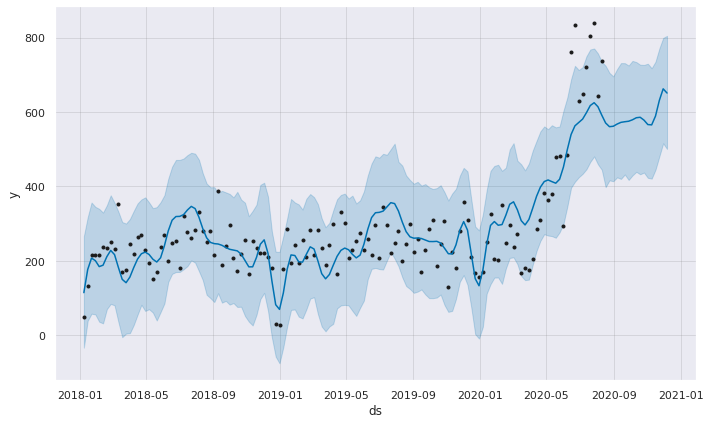

In [10]:
additiveModel.plot(forecast);

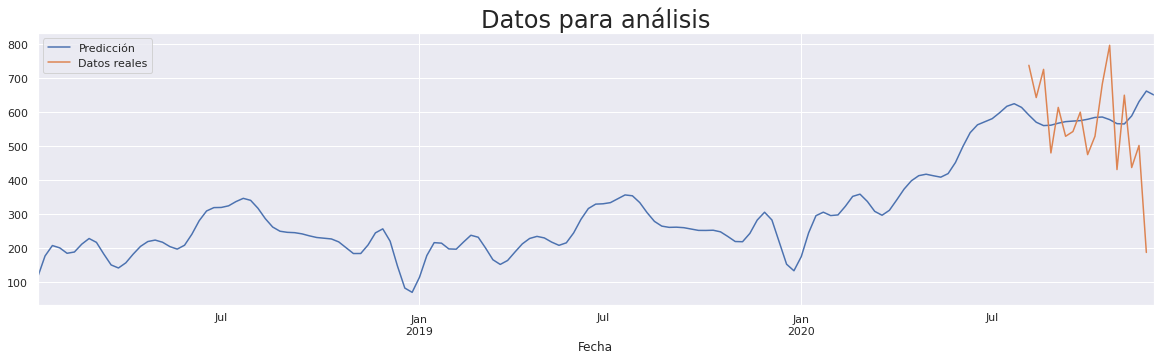

In [11]:
dfrestult = forecast[['ds', 'yhat']]
dfrestult.columns = ['Fecha', 'analizedValue']
dfrestult.set_index('Fecha', inplace=True, verify_integrity=True)

dfrestult.analizedValue.plot(figsize = (20,5), label='Predicción')
df_test.analizedValue.plot(figsize = (20,5), label='Datos reales')
plt.title("Datos para análisis", size= 24)
plt.legend(loc='upper left')
plt.show()

### Resultados modelo multiplicativo

In [12]:
# Generar fechas futuras en base a los datos de prueba
future = multiplicativeModel.make_future_dataframe(periods=len(df_test),freq = 'W-Mon') # 2 años adicionales

forecast = multiplicativeModel.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
148,2020-11-09,578.200828,349.160420,587.508119,569.235130,587.135916,-0.196324,-0.196324,-0.196324,-0.196324,-0.196324,-0.196324,0.0,0.0,0.0,464.686250
149,2020-11-16,584.473033,384.539310,637.654462,574.455571,594.183844,-0.119531,-0.119531,-0.119531,-0.119531,-0.119531,-0.119531,0.0,0.0,0.0,514.610244
150,2020-11-23,590.745237,477.244694,726.202565,579.651193,601.604836,0.018187,0.018187,0.018187,0.018187,0.018187,0.018187,0.0,0.0,0.0,601.489341
151,2020-11-30,597.017441,545.348836,786.657638,584.662263,608.648235,0.108557,0.108557,0.108557,0.108557,0.108557,0.108557,0.0,0.0,0.0,661.827969
152,2020-12-07,603.289645,500.676625,755.884587,589.665991,615.906097,0.040633,0.040633,0.040633,0.040633,0.040633,0.040633,0.0,0.0,0.0,627.803264


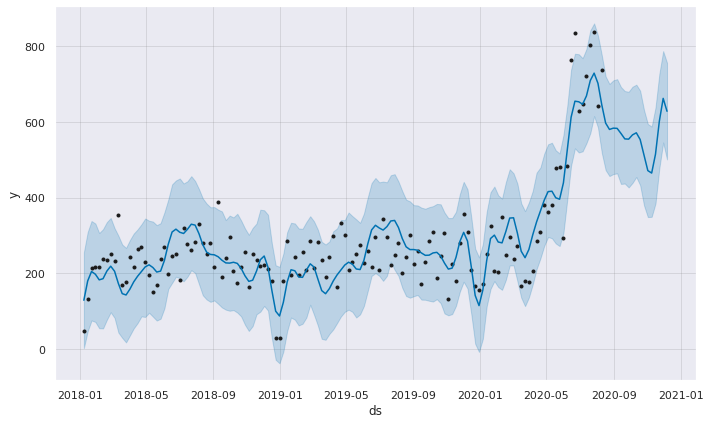

In [13]:
multiplicativeModel.plot(forecast);

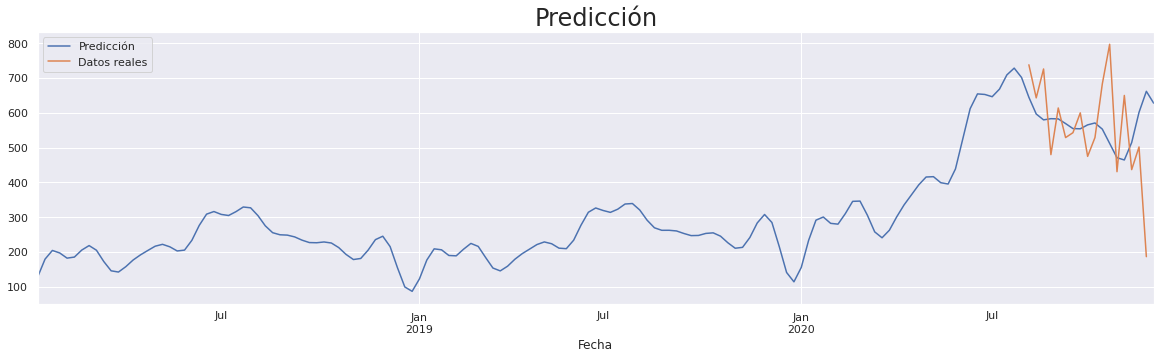

In [14]:
dfrestult = forecast[['ds', 'yhat']]
dfrestult.columns = ['Fecha', 'analizedValue']
dfrestult.set_index('Fecha', inplace=True, verify_integrity=True)

dfrestult.analizedValue.plot(figsize = (20,5), label='Predicción')
df_test.analizedValue.plot(figsize = (20,5), label='Datos reales')
plt.title("Predicción", size= 24)
plt.legend(loc='upper left')
plt.show()

## Pronóstico con RNN

### Escalado de datos

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_train)

scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

### Generación de serie temporal

In [20]:

from keras.preprocessing.sequence import TimeseriesGenerator

# Definimos el generator
n_input = frecuencia # este valor deberia depender del valor estacional
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

print(len(generator)) # n_input = 2

X,y = generator[0]

print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

128
Datos: 
[0.02469136 0.12962963 0.2308642  0.23333333 0.23209877 0.25802469
 0.25555556 0.27530864]
Predicción: 
 [[0.25308642]]


### Entrenamiento

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


# creacion del modelo
model = Sequential()
#Primera capa
model.add(LSTM(units=100, return_sequences = True, activation='tanh', input_shape=(n_input, n_features)))
#ratioDesactivacionNodos = 0.2
#model.add(Dropout(ratioDesactivacionNodos))

#Segunda capa
model.add(LSTM(units=100, activation='tanh', input_shape=(n_input, n_features)))
#ratioDesactivacionNodos2 = 0.2
#model.add(Dropout(ratioDesactivacionNodos2))
#capa de salida
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

print(model.summary())

# entrenamiento
model.fit_generator(generator,epochs=200, steps_per_epoch= 50)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8, 100)            40800     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
50/50 [==============================] - 3s 7ms/step - loss: 0.0619
Epoch 2/200
50/50 [==============================] - 0s 8ms/step - loss: 0.0122
Epoch 3/200
50/50 [==============================] - 1s 10ms/step - loss: 0.0083
Epoch 4/200
50/50 [==============================] - 1s 11ms/step - loss: 0.0103
Epoch 5/200
50/50 [==============================] 

### Resultados

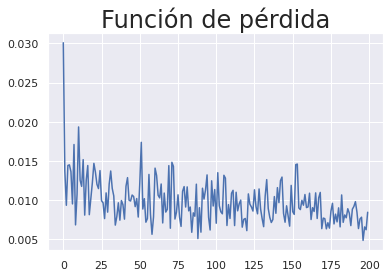

In [35]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title("Función de pérdida", size= 24)
plt.show()

In [36]:
df_test.iloc[:].values

array([[738],
       [643],
       [726],
       [480],
       [614],
       [529],
       [543],
       [600],
       [475],
       [529],
       [683],
       [797],
       [431],
       [650],
       [437],
       [502],
       [187]])

In [37]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Conversion de datos escalados al valor original
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

import math
from sklearn.metrics import mean_squared_error

# Error cuadratico medio
rmse = math.sqrt(mean_squared_error(df_test.iloc[:].values, true_predictions))
rango = max(df_test.iloc[:].values) - min(df_test.iloc[:].values)
print(rmse/rango)



[0.35653079]


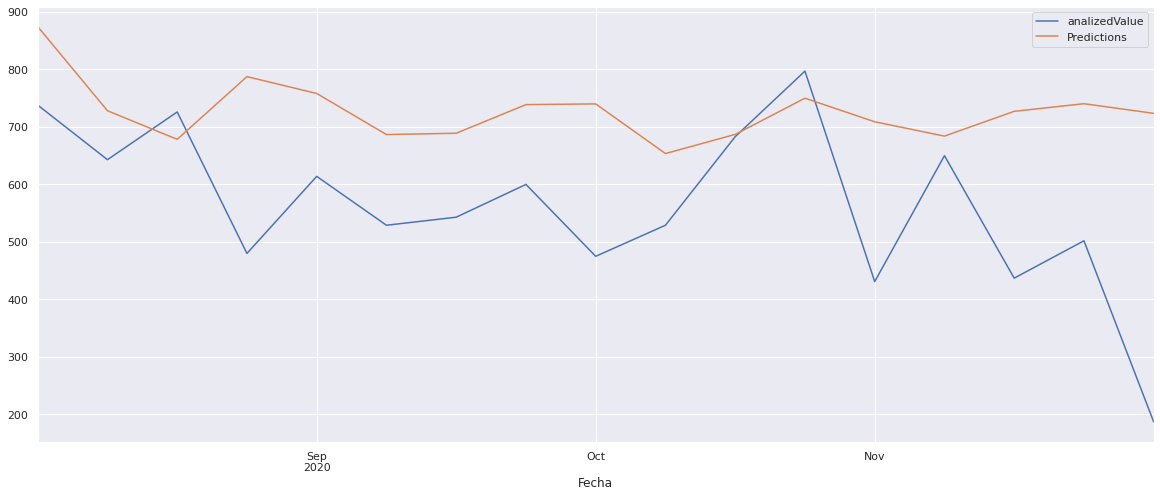

In [38]:
result = df_test.copy()
result['Predictions'] = true_predictions
result.plot(figsize=(20,8))